In [841]:
import numpy as np
from scipy.stats import kde

import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dst
from torch.autograd.functional import jacobian

import matplotlib.pyplot as plt
import time

In [639]:
class PlanarFlow(nn.Module):

    def __init__(self, D):
        super().__init__()
        self.w = nn.Parameter(data=torch.randn(D, 1))
        self.u = nn.Parameter(data=torch.zeros(1, D))
        self.b = nn.Parameter(data=torch.randn(1, 1))
        
    #@property
    #def u_hat(self):
    #    w = self.w.detach()
    #    w_dot_u = self.u @ w
    #    return self.u + (-1 + torch.log(1 + torch.exp(w_dot_u)) - w_dot_u) * (w.T) / (torch.norm(w)) ** 2
        
    def forward(self, z):
        return z + self.u * torch.tanh(z @ self.w + self.b)

In [642]:
def batch_jacobian(f, x):
    f_sum = lambda x: torch.sum(f(x), axis=0)
    return jacobian(f_sum, x, create_graph=True).permute(1,0,2)

In [643]:
#def easy_func(xs):
#    return xs @ torch.tensor([[3., 4.], [5., 6.]])

# batch_jacobian(easy_func, torch.randn(100, 2))
#torch.linalg.slogdet(batch_jacobian(easy_func, torch.randn(100, 2)))

In [644]:
class NormalizingFlowInefficient(nn.Module):
    
    def __init__(self, D=2, K=100):
        super().__init__()
        self.μ = nn.Parameter(torch.zeros(D, ))
        self.pre_σ = nn.Parameter(data=torch.zeros(D, ))
        self.q_0 = dst.multivariate_normal.MultivariateNormal(self.μ, torch.eye(D) * torch.exp(self.pre_σ))
        self.layers = [PlanarFlow(D) for _ in range(K)]
        self.transformation = nn.Sequential(*self.layers)
        
    def sample_from_each_layer(self, n):
        z_0 = self.q_0.sample(sample_shape=(n, ))
        zs = [z_0]
        z = z_0
        for layer in self.layers:
            z = layer(z)
            zs.append(z)
        return zs
    
    def sample_and_return_log_prob(self, n):
        z_0 = self.q_0.rsample(sample_shape=(n, ))  # use rsample so that we can train self.μ and self.pre_σ
        logabsdet = torch.linalg.slogdet(batch_jacobian(self.transformation, z_0))[1]
        z_K = self.transformation(z_0)
        return z_0, z_K, self.q_0.log_prob(z_0) - logabsdet

## Potential function

### My custom potential function

In [825]:
def U_with_argument(z, angle, distance):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2) + 
        1e-5
    )
    return (term1 - term2)

In [826]:
def U_eight(z):
    return U_with_argument(z, torch.pi/4, 3) + \
           U_with_argument(z, torch.pi / 2 + torch.pi/4, 3) + \
           U_with_argument(z, 0, 3) + \
           U_with_argument(z, torch.pi / 2, 3)

### Other potential functions from paper

In [808]:
def w1(z): return torch.sin(2 * torch.pi * z[:, 0] / 4)                 
def w2(z): return 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.5) ** 2)
def σ(x): return 1 / (1 + torch.exp(-x))
def w3(z): return 3 * σ((z[:, 0] - 1) / 0.3)

In [809]:
def taper(z):
    return torch.sigmoid(
        ( 5 - torch.linalg.vector_norm(z, dim=1, ord=np.inf) ) * 10
    )

In [810]:
def add_taper(potential):
    def new_potential(z):
        # so density is exp(-potential(z) + log(taper(z))) = exp(-potential(z)) * taper(z)
        return potential(z) - torch.log(taper(z))  
    return new_potential

In [834]:
def U1(z):
    part_1 = (1/2) * ((torch.sqrt(z[:,0] ** 2 + z[:,1]**2) - 2) / 0.4) ** 2
    part_2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - 2) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + 2) / 0.6) ** 2)
    )
    return (part_1 - part_2)

In [835]:
@add_taper
def U2(z):
    return ((1/2) * ((z[:,1] - w1(z)) / 0.4) ** 2)

In [836]:
@add_taper
def U3(z):
    return - torch.log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    )

In [837]:
@add_taper
def U4(z):
    return - torch.log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.34) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    )

## Choosing a potential function

In [874]:
potential = "U8"

if potential == "U1":
    U = U1
elif potential == "U2":
    U = U2
elif potential == "U3":
    U = U3
elif potential == "U4":
    U = U4
elif potential == "U8":
    U = U_eight

## Graphing potential function

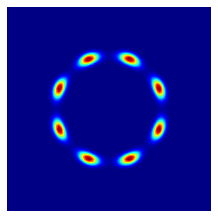

In [875]:
fig = plt.figure(figsize=(3.75, 3.75))

xs = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, xs)
xxs2, yys2 = xxs.reshape(-1, 1), yys.reshape(-1, 1)
unnorm_p = torch.exp(- U(torch.hstack([xxs2, yys2]))) #* decay(torch.hstack([xxs2, yys2]))

plt.contourf(xxs.numpy(), yys.numpy(), unnorm_p.reshape(100, 100).numpy(), levels=100, cmap="jet")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"{potential}_true_density.png", dpi=300, bbox_inches='tight')

## Training

In [876]:
flow = NormalizingFlowInefficient()
opt = optim.Adam(flow.parameters(), lr=2e-3)

start = time.perf_counter()

for i in range(1, 30001):
    
    _, samples_from_q_K, log_probs = flow.sample_and_return_log_prob(n=1000)
    sample_kl = (log_probs + U(samples_from_q_K)).mean()  # monte-carlo estimate of the kl-divergence
    
    opt.zero_grad()
    sample_kl.backward(retain_graph=True)  # I honestly don't understand why retain_graph=True is needed ...
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
        
        for layer in flow.layers:
            assert (float(layer.u @ layer.w) > -1)
            
end = time.perf_counter()
end - start

100 13.732675552368164
200 10.137288093566895
300 8.97249984741211
400 8.657505989074707
500 8.597501754760742
600 8.32496452331543
700 8.226412773132324
800 8.153986930847168
900 8.162725448608398
1000 8.140687942504883
1100 8.081088066101074
1200 8.092832565307617
1300 8.112079620361328
1400 8.061487197875977
1500 8.050704956054688
1600 8.035921096801758
1700 8.052119255065918
1800 8.047514915466309
1900 8.048320770263672
2000 8.078344345092773
2100 8.038300514221191
2200 8.033116340637207
2300 8.030405044555664
2400 8.018309593200684
2500 8.024269104003906
2600 8.029152870178223
2700 8.010696411132812
2800 8.008606910705566
2900 8.026850700378418
3000 8.025290489196777
3100 8.012152671813965
3200 8.004892349243164
3300 8.025372505187988
3400 8.003677368164062
3500 8.018609046936035
3600 8.00752067565918
3700 8.008630752563477
3800 8.00190258026123
3900 7.999803066253662
4000 7.996402263641357
4100 8.011112213134766
4200 7.999917030334473
4300 8.006654739379883
4400 8.009427070617676

1035.1797717080008

## Invertibility check

In [877]:
for layer in flow.layers:
    assert (float(layer.u @ layer.w) > -1)

## Graphing

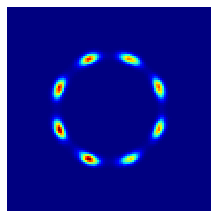

In [878]:
fig = plt.figure(figsize=(3.75, 3.75))

_, samples_qK, _ = flow.sample_and_return_log_prob(n=int(1e6))
samples_qK = samples_qK.detach().numpy()

#samples_qK = samples_qK[np.bitwise_and(samples_qK[:,0] >= -4 , samples_qK[:,0] <= 4)]

# plt.hexbin(samples_qK[:,0], samples_qK[:,1], gridsize=50, cmap="turbo", extent=[-4, 4, -4, 4])
plt.hist2d(samples_qK[:,0], samples_qK[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])
    
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"{potential}_learned_density.png", dpi=300, bbox_inches='tight')

In [879]:
phi = np.linspace(0, 2*np.pi, n)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = (np.stack((np.cos(phi          ), # Three sinusoids,
                       np.cos(phi+2*np.pi/3), # 120° phase shifted,
                       np.cos(phi-2*np.pi/3)
                      )).T # Shape = (60,3)
             + 1)*0.5   

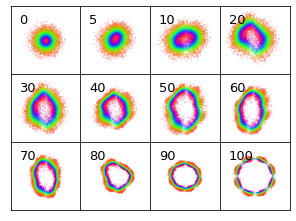

In [880]:
n = 10000

samples_from_each_layer = flow.sample_from_each_layer(n=n)
samples_from_each_layer = [samples.detach().numpy() for samples in samples_from_each_layer]

indices = np.argsort(
    (samples_from_each_layer[0][:,0] - float(flow.μ[0])) ** 2 + 
    (samples_from_each_layer[0][:,1] - float(flow.μ[1])) ** 2
)

fig = plt.figure(figsize=(5, 5 / 4 * 3), )
for i, j in enumerate([0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    fig.add_subplot(3, 4, i+1)
    plt.scatter(samples_from_each_layer[j][:,0][indices], 
                samples_from_each_layer[j][:,1][indices], 
                color=rgb_cycle,
                s=0.01, alpha=1)
    plt.text(-4.5, 3, f"{j}", size=13)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.xticks([])
    plt.yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f"{potential}_samples_from_each_layer.png", dpi=300, bbox_inches='tight')

## Unused code

In [ ]:
# connecting lines between points in q0 and points in qk

# samples_q0, samples_qK, _ = flow.sample_and_return_log_prob(n=1000)
# samples_q0 = samples_q0.detach().numpy()
# samples_qK = samples_qK.detach().numpy()

# for i in range(len(samples_q0)):
#     plt.plot([samples_q0[i][0] + 5, samples_qK[i][0]], 
#              [samples_q0[i][1] + 5, samples_qK[i][1]], 
#              color="black", linewidth=0.2, alpha=0.1)

# plt.scatter(samples_q0[:,0] + 5, samples_q0[:,1] + 5, s=5, color="green", alpha=0.1)
# plt.scatter(samples_qK[:,0], samples_qK[:,1], s=5, color="red", alpha=0.1)
    
# #plt.xlim(-4, 4)
# #plt.ylim(-4, 4)
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("flow.png", dpi=300)

In [ ]:
# density plot with Gaussian KDE

# _, samples_qK, _ = flow.sample_and_return_log_prob(n=100000)
# samples_qK = samples_qK.detach().numpy()

# x, y = samples_qK[:,0], samples_qK[:,1]
# nbins = 50
# xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), nbins), np.linspace(y.min(), y.max(), nbins))

# k = kde.gaussian_kde(samples_qK.T, bw_method=0.02)
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# plt.contourf(xi, yi, zi.reshape(xi.shape), levels=20, cmap="turbo")

# plt.xlim(-4, 4)
# plt.ylim(-4, 4)
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("u4_density_estimated.png", dpi=1000)